In [14]:
# General Imports
import gpytorch
import torch
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook
from matplotlib import pyplot as plt

# Imports from within the repo
import src.utils
from src.utils import set_gpytorch_settings
from src.custom_kernel import noise_lower, noise_upper, noise_init
set_gpytorch_settings()

# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel, RQKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


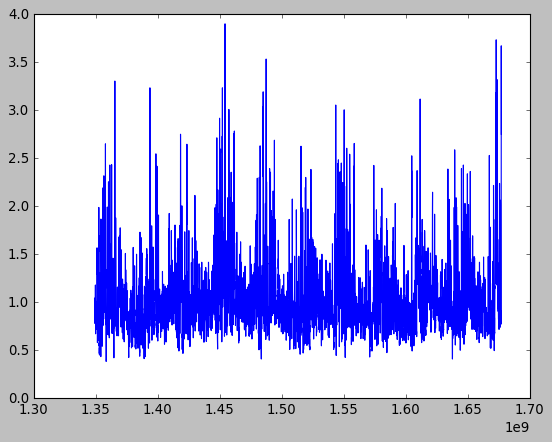

In [15]:
# Designate the parameters to be used
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']

df = pd.read_feather('../data/feather/46221_9999_wave_height.feather')
# df = pd.read_feather('../data/feather/combined/combined_data.feather')

# Perform the block reduction which replaces all the NOAA non-data values with NaNs
# and then takes the mean of each 12-hour period (which comes out to be 24 days values)
# since there are 2 values per day
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
plt.plot(using_sk[:-1,0], using_sk[:-1,1]) # Plots the time vs selected parameter (wave height)

# Local functions and classes

# Function used to scale the data to be between 0 and 1
def scaler(a, X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)

# Model that is used in this experiment
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
# Creat the tensors that will be used and cast them to floats and then to cuda
X = torch.tensor(using_sk[:-1,0]).float().cuda()#.type(torch.double)
y = torch.tensor(using_sk[:-1,1]).float().cuda()#.type(torch.double)
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X

X = scaler(X, X_old)
y = y.log()

In [17]:
# Split the data into a training and testing set
# In this example the test set is simply the last 800 values
test_n = 800
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [18]:
# Define the Kernels that will be used frequently in this experiment
kernel_dict = {
    MaternKernel(): 'Matern Kernel',
    AR2Kernel(): 'Auto Regressive Kernel (2)',
    LinearKernel(): 'Linear Kernel',
    RBFKernel(): 'RBF Kernel',
    PeriodicKernel(): 'Periodic Kernel',
    RQKernel(): 'Rational Quadratic Kernel',
}

Training_exactGPPeriodic Kernel Optimization:   0%|          | 0/1000 [00:00<?, ?it/s]

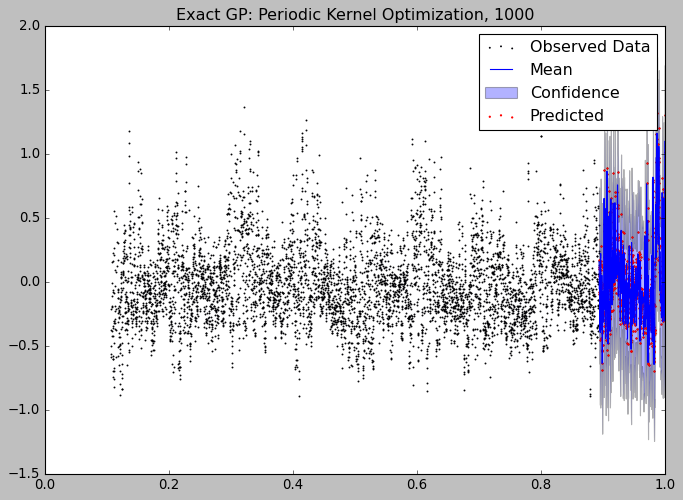

AttributeError: 'ScaleKernel' object has no attribute 'kernel'

In [19]:
## Kernel Optimization for Periodicity ##

# Define the kernels that will be used
kernel_0 = ScaleKernel(RBFKernel())
kernel_1 = ScaleKernel(PeriodicKernel() * RBFKernel())
kernel_2 = ScaleKernel(PeriodicKernel() * RBFKernel() + MaternKernel(nu=2.5))
kernel_3 = ScaleKernel(PeriodicKernel() * RBFKernel() + MaternKernel(nu=1.5))
kernel_4 = ScaleKernel(PeriodicKernel() * RBFKernel() + MaternKernel(nu=0.5))

k_list = [kernel_0, kernel_1, kernel_2, kernel_3, kernel_4]
bic_save = []
kernel_list = []
for kernel in k_list[1:]:
    exact_gp = src.utils.TrainTestPlotSaveExactGP(
        ExactGPModel, kernel,
        train_x, train_y, test_x, test_y,
        num_iter=1000, lr=0.015,
        name=f'Periodic Kernel Optimization',)
    exact_gp.test_eval_exact_gp()
    exact_gp.plot()
    bic_save.append(exact_gp.get_BIC())
    print(bic_save[-1], kernel.kernels[1].base_kernel.period_length_constraint.lower_bound)


In [35]:
print(kernel.base_kernel.kernels[0].raw_period_length_constraint)#.period_length_constraint.lower_bound
kernel.base_kernel.kernels[0].period

Positive()


AttributeError: 'PeriodicKernel' object has no attribute 'period'